# To start with

This notebook will provide information about average profit of basic stock trading strategies and then we will try to extend these signals by using other models

# Plan


1.   Set up the data
2.   Try strategy with different technical indicators on 5 actions
3.   Write strategy, that gets the maximum out of predicted row on 1 and n steps 
4.   One and multi stock investing



In [ ]:
import urllib.request
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Setting up the data

# Yfinance

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf

In [ ]:
data = yf.download('YNDX','2020-01-01',datetime.now())

[*********************100%***********************]  1 of 1 completed


In [ ]:
data = yf.download('SBER.ME','2016-01-01','2021-03-15')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head(8)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,101.000000,101.779999,97.940002,98.010002,61.829746,51264550
2016-01-05,97.879997,99.239998,97.160004,98.889999,62.384892,49071570
2016-01-06,98.699997,99.559998,96.830002,96.849998,61.097954,40710930
2016-01-11,93.610001,94.889999,91.010002,91.029999,57.426407,86120290
2016-01-12,89.089996,92.879997,88.519997,91.709999,57.855373,110109050
2016-01-13,92.750000,93.879997,91.250000,91.500000,57.722904,74169700
2016-01-14,91.000000,93.150002,90.370003,93.040001,58.694408,81220992
2016-01-15,92.440002,92.949997,86.849998,87.269997,55.054390,133791200


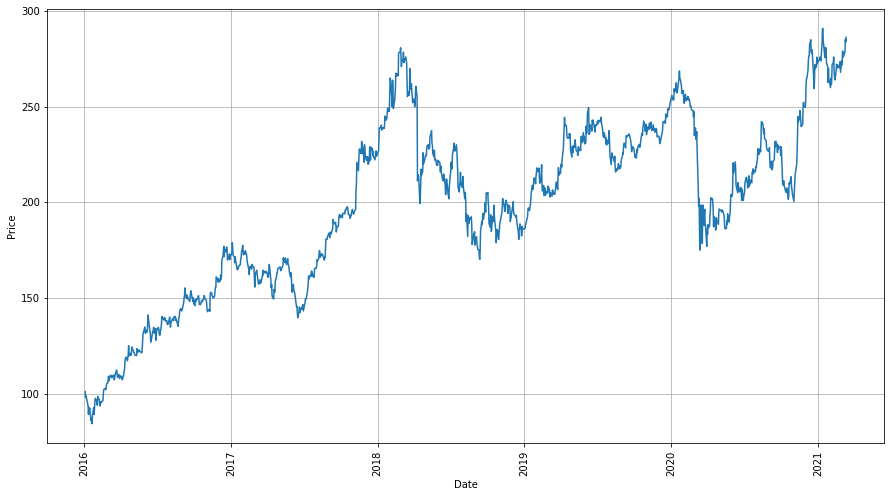

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(data['Open'])
plt.xticks(rotation='vertical')
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid()

In [ ]:
# lets make column of profit and profit in percents
open_price = np.array(data['Open'])
profit = np.array([open_price[i] - open_price[i-1] if i != 0  else 0 for i in np.arange(0, open_price.shape[0])])
profit_percent = np.array([((open_price[i] - open_price[i-1]) / open_price[i-1])*100 if i != 0  else 0  for i in np.arange(0, open_price.shape[0])])

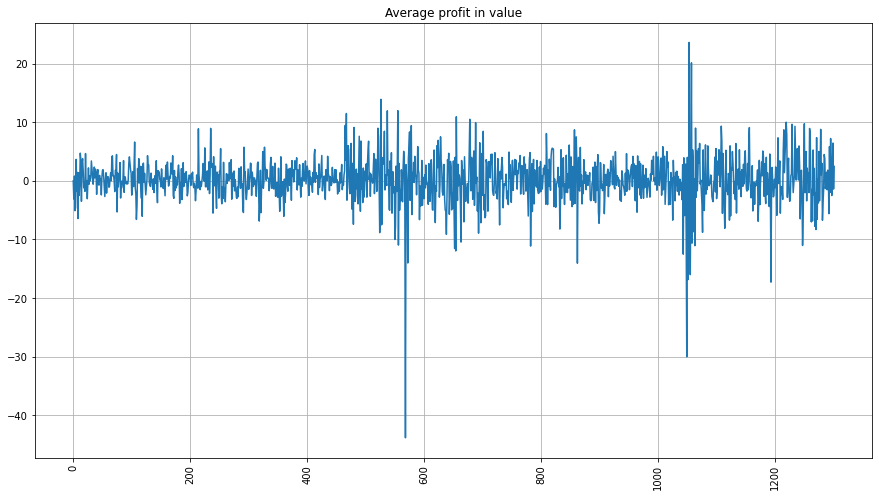

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(profit)
plt.xticks(rotation='vertical')
plt.title('Average profit in value')
plt.grid()

Text(0, 0.5, 'days')

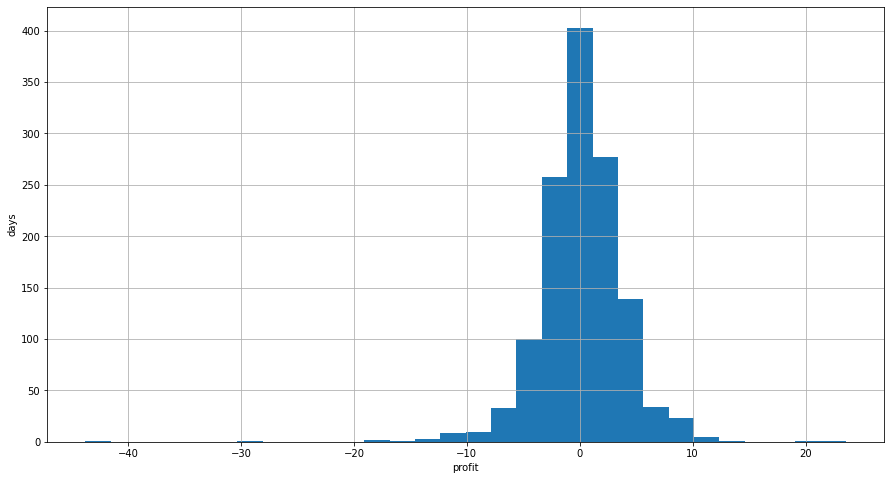

In [ ]:
plt.figure(figsize=(15,8))
plt.hist(profit, bins = 30)
plt.grid()
plt.xlabel('profit')
plt.ylabel('days')

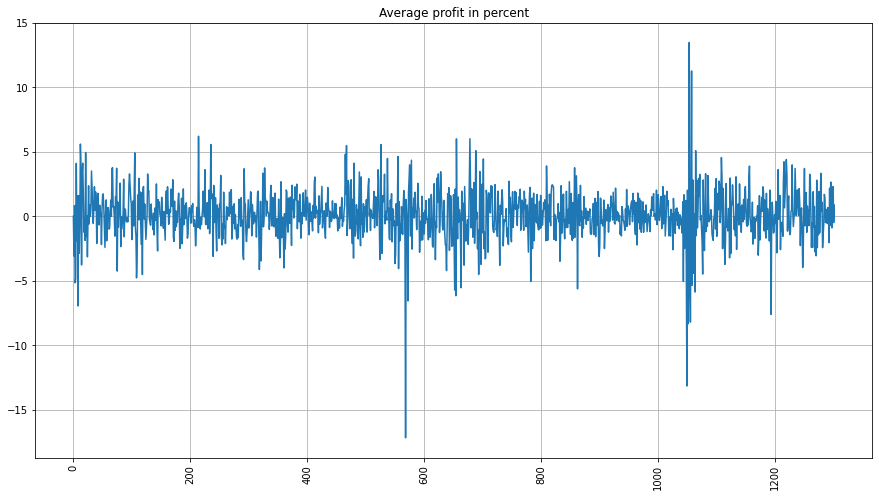

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(profit_percent)
plt.xticks(rotation='vertical')
plt.title('Average profit in percent')
plt.grid()

Text(0, 0.5, 'days')

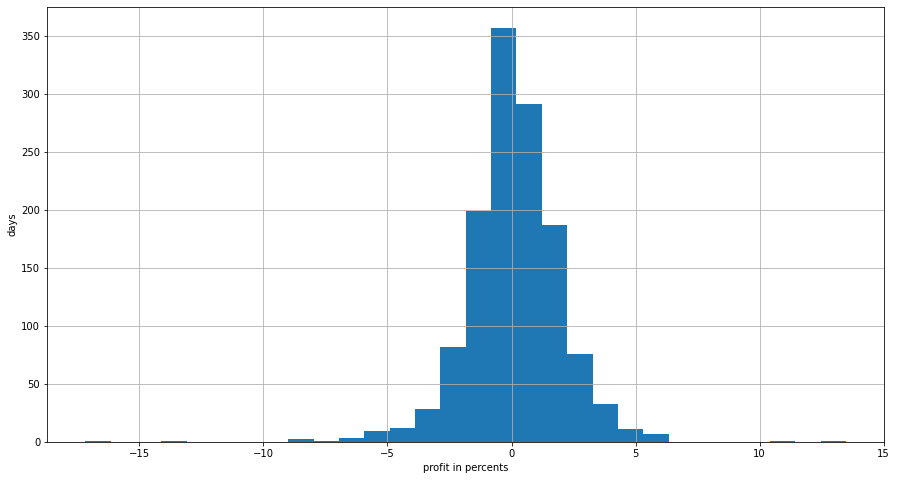

In [ ]:

plt.figure(figsize=(15,8))
plt.hist(profit_percent, bins = 30)
plt.grid()
plt.xlabel('profit in percents')
plt.ylabel('days')

In [ ]:
print('average daily profitability in percent', profit_percent.mean())
print('average daily profitability', profit.mean())

average daily profitability in percent 0.09897794837075953
average daily profitability 0.14231949907294067


# tech indicators

## SMA (simple moving average)

### function realisation

In [ ]:
def SMA(ndays = 200, data: pd.Series = data):
    rolling_mean = data['Open'].rolling(window=ndays).mean()

    return rolling_mean

In [ ]:
SMA_20 = SMA(20, data)
SMA_50 = SMA(50, data)
SMA_70 = SMA(70, data)

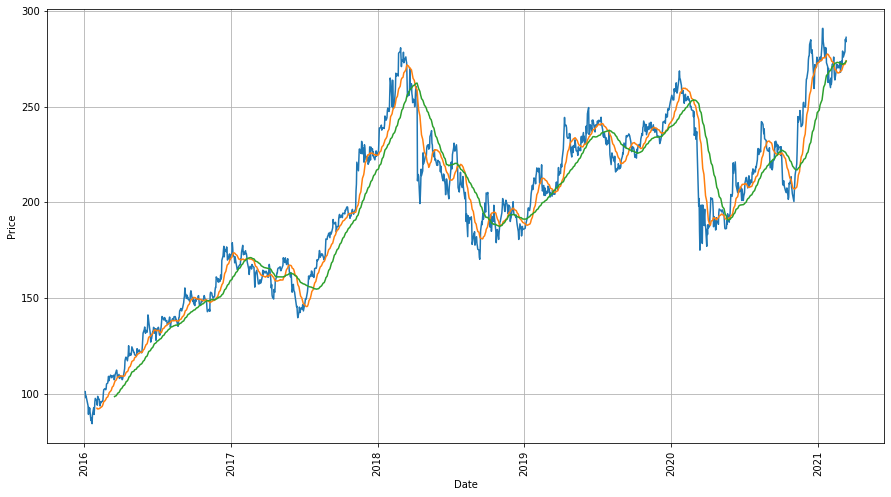

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(data['Open'])
plt.plot(SMA_20)
plt.plot(SMA_50)
#plt.plot(SMA_70)

plt.xticks(rotation='vertical')
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid()

### profitability check

In [ ]:
def buy(n_stocks, cash, price, logging):
    if cash > price:
      n_stocks += np.floor(cash / price)
      cash -= price * np.floor(cash / price)

      if logging:
        print('overall', cash + n_stocks * price)
        print('bought', n_stocks, 'stocks on price', price)
        print('remaining cash', cash, 'remaining stocks', n_stocks)
        print()
    else:
      if logging:
        print('overall', cash + n_stocks * price)
        print('passed because no money', n_stocks, 'stocks on price', price)
        print('remaining cash', cash, 'remaining stocks', n_stocks)
        print()
    return n_stocks, cash, cash + n_stocks * price

def sell(n_stocks, cash, price, logging):
    if n_stocks > 0:
      cash += n_stocks * price
      n = n_stocks
      n_stocks = 0

      if logging:
        print('overall', cash)
        print('sold', n, 'stocks on price', price)
        print('remaining cash', cash, 'remaining stocks', n_stocks)
        print()
    else:
      if logging:
        print('overall', cash)
        print('passed because no stocks', n_stocks, 'stocks on price', price)
        print('remaining cash', cash, 'remaining stocks', n_stocks)
        print()

    return n_stocks, cash, cash

def SMA_trade(lon = 50, short = 20, n_stocks = 1, cash = 0, data = data, logging = False):
    sma_s = SMA(short, data)
    sma_l = SMA(lon, data)

    overall_0 = cash + data['Open'][0] * n_stocks
    overall = cash + data['Open'][0] * n_stocks
    
    for i in np.arange(lon, sma_l.shape[0]):
      price = data['Open'][i]

      if np.abs(sma_s[i] - sma_l[i]) <= 0.3:
        if sma_s[i-1] > sma_l[i-1]:
          n_stocks, cash, overall = sell(n_stocks, cash, price, logging)
        if sma_s[i-1] < sma_l[i-1]:
          n_stocks, cash, overall = buy(n_stocks, cash, price, logging) 
        
        if logging : print(i+lon, 'day')


    return n_stocks, cash, ((overall/overall_0)-1) / (sma_l.shape[0] - lon) * 365

def check_basic_profit(lon = 50, data = data):
    return ((data['Open'][-1] / data['Open'][lon]) , (data['Open'].shape[0] - lon))


In [ ]:
print('Basic profitability of action', check_basic_profit(50, data)[0] / check_basic_profit(50, data)[1] * 365 - 1, 'days')

print('average yearly profitability', SMA_trade(50, 20, 0, 10000)[2])
print('average yearly profitability', SMA_trade(60, 30, 0, 10000)[2])
print('average yearly profitability', SMA_trade(40, 10, 0, 10000)[2])
print('average yearly profitability', SMA_trade(35, 15, 0, 10000)[2])

Basic profitability of action -0.23837892560014962 days
average yearly profitability 0.1946039251504234
average yearly profitability 0.11041363999002798
average yearly profitability 0.03548601926752201
average yearly profitability 0.1935084689350324


In [ ]:
SMA_trade(40, 10, 0, 10000, data, logging=True)

overall 10000
passed because no stocks 0 stocks on price 148.38999938964844
remaining cash 10000 remaining stocks 0

239 day
overall 10000
passed because no stocks 0 stocks on price 148.8000030517578
remaining cash 10000 remaining stocks 0

240 day
overall 10000
passed because no stocks 0 stocks on price 148.00999450683594
remaining cash 10000 remaining stocks 0

241 day
overall 10000.0
bought 66.0 stocks on price 149.99000549316406
remaining cash 100.65963745117188 remaining stocks 66.0

260 day
overall 11021.020080566406
sold 66.0 stocks on price 165.4600067138672
remaining cash 11021.020080566406 remaining stocks 0

303 day
overall 11021.020080566406
bought 63.0 stocks on price 173.94000244140625
remaining cash 62.7999267578125 remaining stocks 63.0

313 day
overall 10457.170272827148
sold 63.0 stocks on price 164.99000549316406
remaining cash 10457.170272827148 remaining stocks 0

321 day
overall 10457.170272827148
bought 62.0 stocks on price 167.5399932861328
remaining cash 69.690

(40.0, 86.94126892089844, 0.03548601926752201)

## MACD

### function realisation

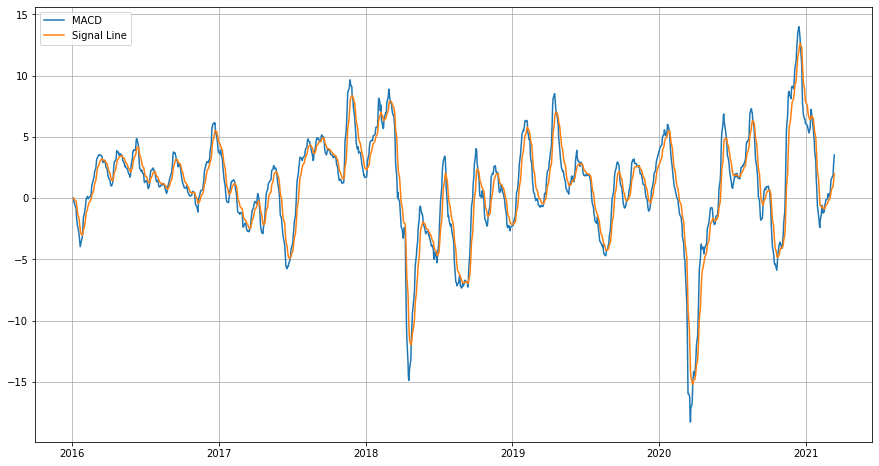

In [ ]:
plt.figure(figsize=(15,8))

exp1 = data['Open'].ewm(span=12, adjust=False).mean()
exp2 = data['Open'].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
exp3 = macd.ewm(span=9, adjust=False).mean()
plt.plot( macd, label='MACD')
plt.plot( exp3, label='Signal Line')
plt.legend(loc='upper left')
plt.grid()

### profit check and trading strategy

In [ ]:
def MACD_trade(p1 = 26, p2 = 12, p3 = 9, n_stocks = 1, cash = 0, data = data, logging = False):
    exp1 = data['Open'].ewm(span=p2, adjust=False).mean()
    exp2 = data['Open'].ewm(span=p1, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=p3, adjust=False).mean()
    
    sma_s = macd
    sma_l = exp3

    overall_0 = cash + data['Open'][0] * n_stocks
    overall = cash + data['Open'][0] * n_stocks
    
    for i in np.arange(p1,  exp3.shape[0]):
      price = data['Open'][i]

      if np.abs( macd[i] -  exp3[i]) <= 0.1:
        if  macd[i-1] >  exp3[i-1]:
          n_stocks, cash, overall = sell(n_stocks, cash, price, logging)
        if  macd[i-1] <  exp3[i-1]:
          n_stocks, cash, overall = buy(n_stocks, cash, price, logging) 
        
        if logging : print(i+p1, 'day')


    return n_stocks, cash, ((overall/overall_0)-1) / ( exp3.shape[0] - p1) * 365

In [ ]:
print('average yearly profitability', MACD_trade(26, 12, 9, 1, 10000, logging=False)[2])
print('average yearly profitability', MACD_trade(40, 20, 15, 1, 10000, logging=False)[2])
print('average yearly profitability', MACD_trade(50, 30, 15, 1, 10000, logging=False)[2])

average yearly profitability 0.16476699236937883
average yearly profitability 0.35395034494273236
average yearly profitability 0.2945222709081188


In [ ]:
MACD_trade(50, 30, 15, 1, 10000, logging=True)

overall 10107.23999786377
sold 1 stocks on price 107.23999786376953
remaining cash 10107.23999786377 remaining stocks 0

112 day
overall 10107.23999786377
passed because no stocks 0 stocks on price 107.62999725341797
remaining cash 10107.23999786377 remaining stocks 0

113 day
overall 10107.23999786377
bought 92.0 stocks on price 108.98999786376953
remaining cash 80.16019439697266 remaining stocks 92.0

114 day
overall 10106.320503234863
passed because no money 92.0 stocks on price 108.9800033569336
remaining cash 80.16019439697266 remaining stocks 92.0

115 day
overall 10476.160194396973
passed because no money 92.0 stocks on price 113.0
remaining cash 80.16019439697266 remaining stocks 92.0

116 day
overall 11382.360054016113
sold 92.0 stocks on price 122.8499984741211
remaining cash 11382.360054016113 remaining stocks 0

139 day
overall 11382.360054016113
passed because no stocks 0 stocks on price 122.48999786376953
remaining cash 11382.360054016113 remaining stocks 0

140 day
overa

(71.0, 152.91303253173828, 0.2945222709081188)

### Conclusion on technical indicators

Average trading strategies based on tech analysis give various profitability in my case from -0.03 to 0.40 with different parameters on different stocks

Average profitability of MACD is although higher then strategy, built with SMA